## Initialization

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import sys  
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore");

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# read labels file
try:
    labels = pd.read_csv('/Users/rraven/Desktop/a_final_yandex/datasets/labels.csv')
except:
    labels = pd.read_csv('/datasets/faces/labels.csv')

labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# check for missing values
labels.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [4]:
# check for duplicates
labels.duplicated().sum()

0

In [5]:
# check distribution
age_range = labels.real_age.value_counts()
age_range

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
100      1
93       1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

In [6]:
# display rows/col
labels.shape

(7591, 2)

__Initial Observations__
- There are 7591 jpg files
- Each file has a file_name and a real_age label
- There are no duplicates
- There are no missing values

## EDA

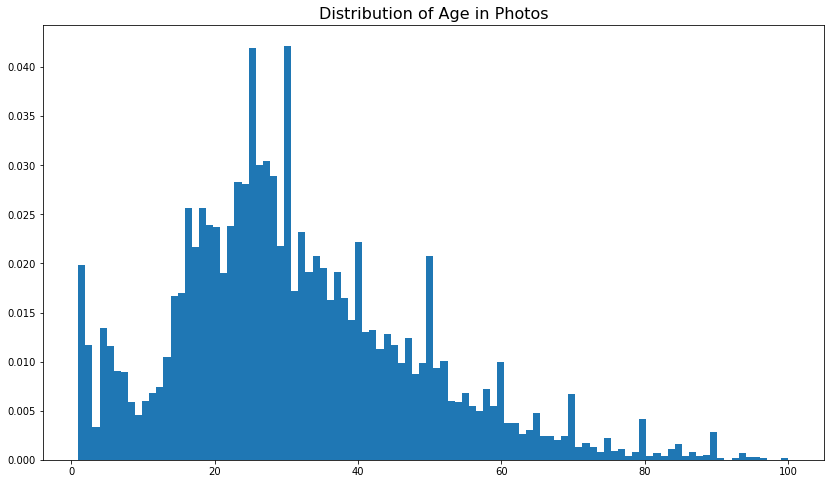

In [7]:
# plot age distribution
plt.figure(figsize=(14,8))
plt.hist(labels.real_age, bins=100, density=True,)
plt.title('Distribution of Age in Photos', fontsize=16)
plt.show() 

In [8]:
# data generator rescale all images
datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# ImageDataGenerator generator for batching images
gen_flow = datagen.flow_from_dataframe(
        # the dataframe/directory 
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), # 150 doesn't work
        batch_size=16, # or 32 works too 
        class_mode='raw', # need raw, not sparse
        seed=12345)

Found 7591 validated image filenames.


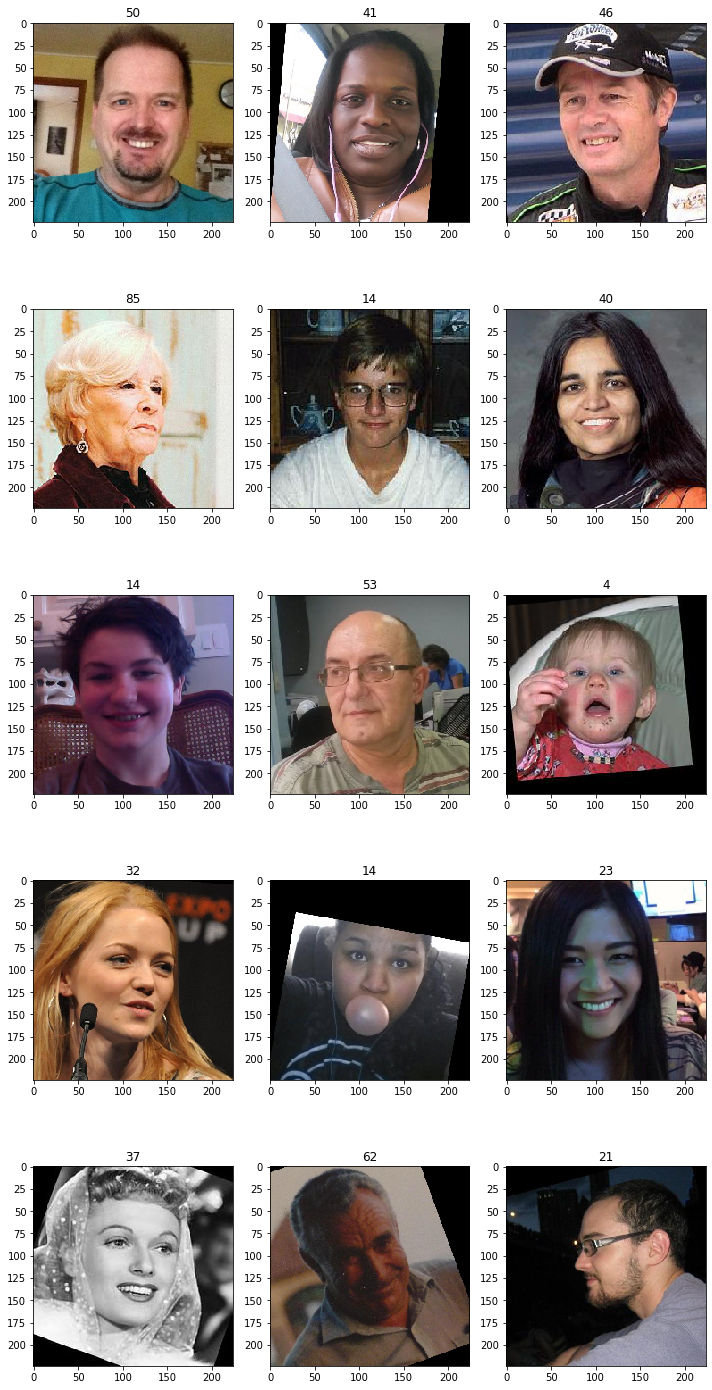

In [10]:
# display sample of photos
def show_batch(batch, predictions=None):
    fig = plt.figure(figsize=(10, 20))

    for i in range(15):
        fig.add_subplot(5, 3, i+1)
        plt.imshow(batch[0][i])
        title = batch[1][i]
        if predictions is not None:
            title = f'gt: {title}, pred: {round(predictions[i])}'
        plt.title(title)

    fig.tight_layout()

show_batch(next(gen_flow))


### Findings

__Observations__
- This is a regression model to predict age on a continuous scale
- Width_shift_range, height_shift_range arguments and horizontal_flip might be useful augmentations
- There output layer only needs one neuron to represent age
- Since this is a regression task, MSE is a suitable loss function
- The ReLu activation function is selected here because it doesn't change the positive numbers, and it brings all the negative ones to zero. There cannot be numbers less than zero.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [12]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [13]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [16]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

2022-03-16 16:42:08.863734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-03-16 16:42:09.504566: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-03-16 16:42:39.229564: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-16 16:42:39.926060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-16 16:42:39.926167: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-03-16 16:42:39.926202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-16 16:42:40.309682: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-03-16 16:42:40.453227: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-03-16 16:42:41.519321: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-03-16 16:42:41.624688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-03-16 16:42:41.624827: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-03-16 16:42:41.629400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-03-16 16:42:41.629805: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-03-16 16:42:41.842086: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-03-16 16:42:41.848608: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5f01f10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-16 16:42:41.848648: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-16 16:42:42.414638: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5f87f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-03-16 16:42:42.414681: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-03-16 16:42:42.417071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-16 16:42:42.417126: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-03-16 16:42:42.417136: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-16 16:42:42.417165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-03-16 16:42:42.417177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-03-16 16:42:42.417186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-03-16 16:42:42.417194: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-03-16 16:42:42.417201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-03-16 16:42:42.421640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-03-16 16:42:42.429309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-03-16 16:42:52.945459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-16 16:42:52.945519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-03-16 16:42:52.945529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-03-16 16:42:52.966376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/18
2022-03-16 16:43:46.388389: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-16 16:43:55.481467: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 155s - loss: 237.9930 - mae: 10.9816 - val_loss: 1009.0761 - val_mae: 27.0720
Epoch 2/18
178/178 - 37s - loss: 79.2152 - mae: 6.6824 - val_loss: 700.9412 - val_mae: 21.2602
Epoch 3/18
178/178 - 37s - loss: 47.9843 - mae: 5.2677 - val_loss: 280.0870 - val_mae: 12.4585
Epoch 4/18
178/178 - 37s - loss: 35.3681 - mae: 4.5447 - val_loss: 125.8393 - val_mae: 8.6939
Epoch 5/18
178/178 - 37s - loss: 27.5020 - mae: 3.9887 - val_loss: 74.9503 - val_mae: 6.5571
Epoch 6/18
178/178 - 37s - loss: 22.8814 - mae: 3.7003 - val_loss: 72.2361 - val_mae: 6.3796
Epoch 7/18
178/178 - 37s - loss: 17.9365 - mae: 3.2325 - val_loss: 71.1385 - val_mae: 6.5479
Epoch 8/18
178/178 - 37s - loss: 15.0660 - mae: 2.9668 - val_loss: 73.7764 - val_mae: 6.2596
Epoch 9/18
178/178 - 37s - loss: 12.1238 - mae: 2.6515 - val_loss: 68.2889 - val_mae: 6.3792
Epoch 10/18
178/178 - 37s - loss: 10.5958 - mae: 2.4629 - val_loss: 74.6193 - val_mae: 6.4174
Epoch 11/18
178/178 - 37s - loss: 9.8817 - mae: 2.3469 - val_loss: 62.4399 - val_mae: 6.0225
Epoch 12/18
178/178 - 37s - loss: 8.7129 - mae: 2.2266 - val_loss: 60.6788 - val_mae: 5.7920
Epoch 13/18
178/178 - 37s - loss: 7.9204 - mae: 2.1344 - val_loss: 78.0248 - val_mae: 6.5433
Epoch 14/18
178/178 - 37s - loss: 7.5437 - mae: 2.0763 - val_loss: 63.6832 - val_mae: 5.9811
Epoch 15/18
178/178 - 37s - loss: 7.4256 - mae: 2.0588 - val_loss: 60.1599 - val_mae: 5.7920
Epoch 16/18
178/178 - 37s - loss: 7.2918 - mae: 2.0241 - val_loss: 67.6098 - val_mae: 5.9541
Epoch 17/18
178/178 - 37s - loss: 7.0888 - mae: 2.0003 - val_loss: 68.3439 - val_mae: 6.0946
Epoch 18/18
178/178 - 37s - loss: 6.7184 - mae: 1.9477 - val_loss: 62.9600 - val_mae: 5.9730
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.9600 - mae: 5.9730
Test MAE: 5.9730

In [17]:
### training code used to with run as a .py file

import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(20, activation='relu')) # added
    model.add(Dense(1, activation='relu'))
    model.summary()
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=18,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
# Runs:
# epochs=20 356/356 - 39s - loss: 24.2850 - mae: 3.8078 - val_loss: 131.8347 - val_mae: 8.7564
# epochs=18 356/356 - 39s - loss: 33.5193 - mae: 4.4797 - val_loss: 119.9507 - val_mae: 8.3903
# epochs=20 and added dense timeout
# epochs 18 learning_rate=0.0005 timeout
# get rid of dense, epoch 24, lr 0.0001, and change batch to 32 - Passed with MAE=5.9730

# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')



## Conclusions

- The overall MAE=5.9730 is below the limit of the score (8.0).
- The model used epochs=24, Adam lr=0.0001, and batch size of 32.
- Changing the batch size from 16 to 32 improved the performance markedly.
- ResNet50 was selected as the backbone.
- ReLU was used as the activation.
- For this model single neuron output indicating the predicted age of the person was created by running a photo through this model.